# Hidden Shift Problem

In this notebook, we introduce the hidden shift problem over bent functions and two different quantum algorithms to solve it. We then implement these algorithms using Qiskit and run on a simulator and device.

## Contents

1. [Introduction](#introduction)  
   1.1 [Hidden Shift Problem over Bent Functions](#hidden-shift-problem-over-bent-functions)  
   1.2 [Fourier-transform-accessible Algorithm](#fourier-transform-accessible-algorithm)  
   1.3 [Fourier-transform-free Algorithm](#fourier-transform-free-algorithm)  
2. [Example](#example)  
3. [Qiskit Implementation](#implementation)  
   3.1 [Fourier-transform-accessible Algorithm](#ftaa)  
   3.2 [Fourier-transform-free Algorithm](#ftfa)  
<!--    3.3 [Integer-Valued Algorithm](#iva)   -->
4. [Problems](#problems)  
<!-- 6. [Cryptanalysis of Poly1305](#poly1305)   -->
5. [References](#references)

## 1. Introduction <a id='introduction'> </a>

The hidden shift problem is an oracle-based problem that is closely related to Simon's problem and factorization problem. There exists an exponential quantum-classical separation for the query complexity of the hidden shift problem over bent functions [1, 2].

Bent functions are a particular type of Boolean functions which are maximally non-linear and hard to approximate by linear or affine functions making them interesting for cryptographic purposes [3].

The known quantum advantage on the extension of the hidden shift problem to modular addition provides a threat to commonly used cryptographic primitives such as Poly1305 and CSIDH [4]. Moreover, those quantum algorithms to solve the hidden shift problem have been used to benchmark quantum computers on different hardware [5, 6].

Therefore, we focus on the hidden shift problem over bent functions in this notebook.

### 1.1 Hidden Shift Problem over Bent Functions <a id='hidden-shift-problem-over-bent-functions'> </a>

Suppose $n$-bit boolean bent functions $f, g: \mathbb{Z}^n_2 \rightarrow \mathbb{Z}_2$ satisfying the relation: $f(x + s) = g(x)$ for some "hidden shift" $s \in \mathbb{Z}^n_2$.

Given an oracle that encodes $f, g$ and possibly Fourier transforms $\tilde{f}, \tilde{g}$, how can we find the hidden shift $s$ while accessing the oracle within a number of times as little as possible?

### 1.2 Fourier-transform-accessible Algorithm <a id='fourier-transform-accessible-algorithm'> </a>

We first present the case when we have access to the Fourier transform $\tilde{f}$. This quantum algorithm was first introduced in Reference [1].

#### 1.2a The Classical Solution

We can compute the general classical complexity of the problem with a brute-force approach, putting in all possible inputs to classify $f(x)$ and $g(x)$. Then it costs $2 \cdot 2^n$ oracle queries. Reference [1] showed that if we have access to the Fourier transform $\tilde{f}$, we can identify $s$ in $\Theta(n)$ queries at best with some Fourier analysis on bent functions.

#### 1.2b The Quantum Solution

Before we learn about the quantum algorithm, we must first talk about the Fourier transform on the boolean group $\mathbb{Z}^n_2$ with bitwise modular addition, $01 + 11 = (0+1, 1+1) = 10$ for example. For any real valued function $f : \mathbb{Z}^n_2 \rightarrow \mathbb{R}$, its Fourier transform is the function $\tilde{f} : \mathbb{Z}^n_2 \rightarrow \mathbb{R}$ defined by:

$$
\tilde{f}(x) = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{x \cdot y}f(y)
$$

It is quite interesting that this specific Fourier transform is called "Hadamard transform", while the Hadamard transform on qubits is defined by:

$$
H \left| x \right> = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{x \cdot y} \left| y \right>,
$$

Now, let's go through the quantum algorithm.

If the oracle lets us access to the Fourier transform, there exists an one-shot algorithm that directly returns $\left| s \right>$:

![hsp_ftaa](images/hsp_ftaa.jpg)

For any given function $f$, the oracle $U$ is an operator that encodes the given function as below:

$$
U_f \left| x \right> = (-1)^{f(x)} \left| x \right> \equiv F(x) \left| x \right>
$$

It operates phase flip on the input state $\left| x \right>$ according to the function value. We simply denote $(-1)^{f(x)} = F(x)$, then we can also benefit from the fact from Fourier analysis: $\tilde{F}(x) = (-1)^{\tilde{f}(x)}$.

Here go the steps of the algorithm shown in the figure:

<ol>
   <li>
        The $n$-qubit register is initialized to the zero state:  
$$
\left| \psi_1 \right> = \left| 0 \right> ^{\otimes n}
$$

   </li>
   
   <li>
        Apply a Hadamard transform to the whole qubits:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| x \right>
$$

   </li>

   <li>
        Query the oracle $U_{g}$:  
$$
\begin{aligned}
    \left| \psi_3 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{x} G(x) \left| x \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x} F(x + s) \left| x \right>
\end{aligned}
$$

   </li>

   <li>
        Apply Hadamard gates again:  
$$
\begin{aligned}
    \left| \psi_4 \right>
        & = \frac{1}{2^n} \sum_{y} \left[ \sum_{x} (-1)^{x \cdot y} F(x + s) \right] \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \left[ \frac{1}{\sqrt{2^n}} \sum_{x} (-1)^{(x + s) \cdot y} F(x + s) \right] \left| y \right>
\end{aligned}
$$

However the term inside square brackets is nothing but $\tilde{F}(y)$:  
$$
= \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \tilde{F}(y) \left| y \right>
$$

   </li>

   <li>
        Query the oracle $U_{\tilde{f}}$:  
$$
\begin{aligned}
    \left| \psi_5 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \tilde{F}(y) \tilde{F}(y) \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \left| y \right>
\end{aligned}
$$
        
   </li>

   <li>
        Finally, retrieve $\left| s \right>$ by cancelling out the Hadamard transform:  
$$
\left| \psi_6 \right> = \left| s \right>
$$
        
   </li>
</ol>

Hence, we can solve the hidden shift problem with one query of $U_g$ and one query of $U_{\tilde{f}}$.

### 1.3 Fourier-transform-free Algorithm <a id='fourier-transform-free-algorithm'> </a>

If the oracle does not provide the Fourier transform, the problem gets exponentially harder, classically. However we can still solve the problem with quantum computers within a linear number of queries. The first idea of this Fourier-transform-free algorithm was first introduced in Reference [1], and then improved in Reference [2]. We employed the latter one in this notebook.

#### 1.3a The Classical Solution

For the case without the access to the Fourier transform, it is proven in Reference [2] that the classical query complexity becomes $\Omega \left( \sqrt{2^n} \right)$, i.e., it requires at least $\sqrt{2^n}$ order of queries. We can just remind that the brute-force approach is in $2^n$ order.

#### 1.3b The Quantum Solution

We can solve the problem in a constant probability with the quantum algorithm below in $O(n)$ queries.

![hsp_ftfa](images/hsp_ftfa.jpg)

For any given function $f$, the oracle $O$ is an operator that encodes the given function as below:

$$
O_f \left| b \right> \left| x \right> = \left| b + f(x) \right> \left| x \right>
$$

It takes inputs from the second register and returns the output to the first register. Note that this oracle $O$ is slightly different from the previous oracle $U$ used in section 1.2.

Now, let's go through the steps shown in the figure:

<ol>
   <li>
        The output register and $n$-qubit input register are initialized to the zero state:  
$$
\left| \psi_1 \right> = \left| 0 \right> \left| 0 \right>^{\otimes n}
$$
   </li>
   
   <li>
        Apply Hadamard gates on the input register to create uniform superposition:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| 0 \right> \left| x \right>
$$

   </li>

   <li>
        Query the oracle $O_f$:  
$$
\left| \psi_3 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| f(x) \right> \left| x \right>
$$

   </li>

   <li>
        Apply Z gate on the output register:  
$$
\left| \psi_4 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} F(x) \left| f(x) \right> \left| x \right>
$$

   </li>

   <li>
        Query the oracle $O_g$:  
$$
\begin{aligned}
    \left| \psi_5 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{x} F(x) \left| f(x) + g(x) \right> \left| x \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x} \left[ \frac{F(x) + G(x)}{2} \left| 0 \right> + \frac{F(x) - G(x)}{2} \left| 1 \right> \right] \left| x \right>
\end{aligned}
$$

   </li>

   <li>
        Apply Hadamard transform on the input register:  
$$
\begin{aligned}
    \left| \psi_6 \right>
        & = \frac{1}{2^n} \sum_{x, y} (-1)^{x \cdot y} \left[ \frac{F(x) + G(x)}{2} \left| 0 \right> + \frac{F(x) - G(x)}{2} \left| 1 \right> \right] \left| y \right> \\
        & = \frac{1}{2^n} \sum_{x, y} \left[ \frac{(-1)^{x \cdot y} F(x) + (-1)^{x \cdot y} F(x + s)}{2} \left| 0 \right> + \frac{(-1)^{x \cdot y} F(x) - (-1)^{x \cdot y} F(x + s)}{2} \left| 1 \right> \right] \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} \left[ \frac{\tilde{F}(y) + (-1)^{s \cdot y} \tilde{F}(y)}{2} \left| 0 \right> + \frac{\tilde{F}(y) - (-1)^{s \cdot y} \tilde{F}(y)}{2} \left| 1 \right> \right] \left| y \right>
\end{aligned}
$$

Then we can simplify the equation with the binary index $b$:  
$$
\begin{aligned}
    & = \frac{1}{\sqrt{2^n}} \sum_{b, y} \tilde{F}(y) \left( \frac{1 + (-1)^{(1, s) \cdot (b, y)}}{2} \right) \left| b \right> \left| y \right>
\end{aligned}
$$

Now we measure the state $\left| b, y \right>$, then the probability of getting a result $\left| b_0, y_0 \right>$ is:  
$$
\begin{aligned}
    P(b_0, y_0)
        & = \left| \left< b_0, y_0 \middle| \frac{1}{\sqrt{2^n}} \sum_{b, y} \tilde{F}(y) \left( \frac{1 + (-1)^{(1, s) \cdot (b, y)}}{2} \right) \middle| b, y \right> \right| ^2 \\
        & = \frac{1}{2^n} \cdot \left| \tilde{F}(y_0) \right| ^2 \cdot \left| \frac{1 + (-1)^{(1, s) \cdot (b_0, y_0)}}{2} \right| ^2 \\
        & = \frac{\delta ((1, s) \cdot (b_0, y_0))}{2^n}
\end{aligned}
$$

The absolute value $\left| \tilde{F}(y_0) \right| = 1$ whenever the function $f$ is bent. Then it clearly states that the result is an uniform superposition of the states that are orthogonal to the state $\left| 1, s \right>$.

Once we get the outputs $(b_1, y_1), (b_2, y_2), \cdots (b_n, y_n)$, we can solve the following equation to find $\left| s \right>$:

$$
\begin{cases}
    s \cdot y_1 = b_1 \\
    s \cdot y_2 = b_2 \\
    \vdots \\
    s \cdot y_n = b_n
\end{cases}
$$

The hidden shift $s$ can be uniquely characterized by $n$ independent $y_i$s, so we repeat the algorithm a total number of $O(n)$ times to get a constant probability to get a sufficient number of bitstrings.

   </li>
</ol>

## 2. Example <a id='example'> </a>

Here is a specific example of the hidden shift algorithm for the case $n=2$ and $s=10$. As the oracle must be able to encode the Fourier transform $\tilde{f}$, we employ the Maiorana-McFarland class of bent functions: $\mathbb{Z}^n_2 \rightarrow \mathbb{Z}_2$ mapping the input string $(x, y) \mapsto f(x, y)$ as below:

$$
f(x, y) = x \cdot y + h(x)
$$

where h(x) is an arbitrary boolean function: $\mathbb{Z}^{n/2}_2 \rightarrow \mathbb{Z}_2$, i.e., any boolean function that takes only half an input. For this special class of bent functions, it is known that:

$$
\tilde{f}(x, y) = x \cdot y + h(y)
$$

In this example, we simply choose $h(x) = x$ to get the output table as below:

| $$(x,y)$$ | $$f(x,y)$$ | $$g(x,y)$$ | $$\tilde{f}(x,y)$$ |
|:--:|:-:|:-:|:-:|
| 00 | 0 | 0 | 0 |
| 01 | 1 | 0 | 0 |
| 10 | 0 | 0 | 1 |
| 11 | 0 | 1 | 0 |

### 2.1 Fourier-Transform-Accessible Algorithm

<ol>
   <li>
        The 2-qubit register is initialized to the zero state:  
$$
\left| \psi_1 \right> = \left| 00 \right>
$$

   </li>
   
   <li>
        Apply a Hadamard transform to the whole qubits:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Query the oracle $U_{g}$:  
$$
\left| \psi_3 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Apply Hadamard gates again:  
$$
\begin{aligned}
    \left| \psi_4 \right> = \frac{1}{2^2} ( \;
        & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[5pt]
        + & \left| 00 \right> - \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \\[6pt]
        + & \left| 00 \right> + \left| 01 \right> - \left| 10 \right> - \left| 11 \right> \\[6pt]
        - & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; )
\end{aligned}
$$

Summing up vertically, we get:
$$
= \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Query the oracle $U_{\tilde{f}}$:  
$$
\left| \psi_5 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> - \left| 10 \right> - \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Finally, retrieve $\left| s \right>$ by cancelling out the Hadamard transform:  
$$
\begin{aligned}
    \left| \psi_6 \right> = \frac{1}{2^2} ( \;
        & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[5pt]
        + & \left| 00 \right> - \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \\[6pt]
        - & \left| 00 \right> - \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[6pt]
        - & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; ) \\[6pt]
    = \left| 10 \right> & = \left| s \right>
\end{aligned}
$$
        
   </li>
</ol>

Here we clearly see that $\left| s \right>$ is directly obtained from the algorithm.

### 2.2 Fourier-Transform-Free Algorithm

<ol>
   <li>
        The output register and $n$-qubit input register are initialized to the zero state:  
$$
\left| \psi_1 \right> = \left| 0 \right> \otimes \left| 00 \right>
$$
   </li>
   
   <li>
        Apply Hadamard gates on the input register to create uniform superposition:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 0 \right> \otimes \left| 00 \right> + \left| 0 \right> \otimes \left| 01 \right> + \left| 0 \right> \otimes \left| 10 \right> + \left| 0 \right> \otimes \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Query the oracle $O_f$:  
$$
\left| \psi_3 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 0 \right> \otimes \left| 00 \right> + \left| 1 \right> \otimes \left| 01 \right> + \left| 0 \right> \otimes \left| 10 \right> + \left| 0 \right> \otimes \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Apply Z gate on the output register:  
$$
\left| \psi_4 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 0 \right> \otimes \left| 00 \right> - \left| 1 \right> \otimes \left| 01 \right> + \left| 0 \right> \otimes \left| 10 \right> + \left| 0 \right> \otimes \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Query the oracle $O_g$:  
$$
\begin{aligned}
    \left| \psi_5 \right> = \frac{1}{\sqrt{2^2}} ( \;
        & \left| 0 \right> \otimes \left| 00 \right> - \left| 1 \right> \otimes \left| 01 \right> + \left| 0 \right> \otimes \left| 10 \right> + \left| 1 \right> \otimes \left| 11 \right> \; ) \\
    = \frac{1}{\sqrt{2^2}} ( \;
        & \left| 0 \right> \otimes \left( \; \left| 00 \right> + \left| 10 \right> \; \right) \\
      + & \left| 1 \right> \otimes \left( \; - \left| 01 \right> + \left| 11 \right> \; \right) \; )
\end{aligned}
$$

   </li>

   <li>
        Apply Hadamard transform on the input register:  
$$
\begin{aligned}
    \left| \psi_6 \right> = \frac{1}{2^2} ( \; \left| 0 \right> \otimes ( \;
        & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[5pt]
    +   & \left| 00 \right> + \left| 01 \right> - \left| 10 \right> - \left| 11 \right> \; ) \\[6pt]
    + \left| 1 \right> \otimes ( \;
        & - \left| 00 \right> + \left| 01 \right> - \left| 10 \right> + \left| 11 \right> \\[6pt]
    +   & \left| 00 \right> - \left| 01 \right> - \left| 10 \right> + \left| 11 \right> \; ) \; ) \\[6pt]
    = \frac{1}{\sqrt{2^2}} ( \; \left| 0 \right> \otimes ( \;
        & \left| 00 \right> + \left| 01 \right> \; ) + \left| 1 \right> \otimes ( \; - \left| 10 \right> + \left| 11 \right> \; ) \; )
\end{aligned}
$$

   </li>
</ol>

Finally we find 4 different outputs $\left| 0 \right> \otimes \left| 00 \right>$, $\left| 0 \right> \otimes \left| 01 \right>$, $\left| 1 \right> \otimes \left| 10 \right>$ and $\left| 1 \right> \otimes \left| 11 \right>$. But we can retrieve $s$ as soon as we get two linearly independent outcomes except for the trivial output $\left| 0 \right> \otimes \left| 00 \right>$. For example, when we get outputs $\left| 0 \right> \otimes \left| 01 \right>$ and $\left| 1 \right> \otimes \left| 11 \right>$, we can compute $s$ as below:

$$
\begin{cases}
    \left<s \mid 01 \right> = 0 = s_2 \\
    \left<s \mid 11 \right> = 1 = s_1 + s_2
\end{cases}
\quad \therefore \left| s \right> = \left| s_1 s_2 \right> = \left| 10 \right>
$$

We get one bit of $s$ for each independent output $y$. Therefore, we see that the query complexity would be probabilistic in $O(n)$. We can also check the dot product $(1, s) \cdot (b, y)$ for all outcomes as below:

| $$(1, s)$$ | $$(b, y)$$ | product |
|:---:|:---:|:-----:|
| 110 | 000 |   0   |
| 110 | 001 |   0   |
| 110 | 110 | 1+1=0 |
| 110 | 111 | 1+1=0 |

## 3. Qiskit Implementation <a id='implementation'> </a>

### 3.1 Fourier-transform-accessible Algorithm <a id='ftaa'> </a>

Now, we will walk through the algorithm which makes use of the Fourier transform. We will implement it via Qiskit for a 4-bit string $s=1011$.

In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

We first set the number of qubits $n$ and the hidden shift $s$.

In [2]:
n = 4         # number of input qubits
s = '1011'    # the binary hidden shift string

The hidden shift $s$, together with some bent function $f$, determines the circuit for the oracle. As we have to implement the Fourier transform $\tilde{f}$, we employ again the Maiorana-McFarland class of bent functions. Here we employ $h(x) = x \cdot e_2$ for example. Then $f$ is defined as below:

$$
f(x, y) = x \cdot y + x \cdot e_2 = (x_1 y_1 + x_2 y_2) + x_2
$$

From now on, we will see how we can use Qiskit to encode the oracles $U_{g}$ and $U_{\tilde{f}}$. We are aiming to check that our algorithm correctly gives the hidden shift $s$ with this specific example.

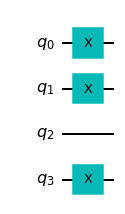

In [3]:
def shift_s(n, s):
    """Shifting operation for the given string s"""
    shift_s = QuantumCircuit(n)
    s = s[::-1]    # reverse s to fit qiskit's qubit ordering
    for i in range(n):
        if s[i] == '0': 
            continue
        else:
            shift_s.x(i)    # apply x gates to shift the input
    shift_s.name = 'Shift'
    return shift_s

# Display circuit
shift_s(n, s).draw('mpl')

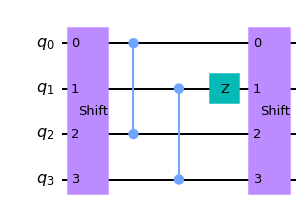

In [4]:
def oracle_g(n):
    """Oracle circuit that encodes g = U_g"""
    oracle_g = QuantumCircuit(n)
    
    # Shift the inputs
    oracle_g.append(shift_s(n, s), range(n))
    
    # Apply the oracle U_f = (-1)^f(x) = F(x)
    # x·y corresponds to controlled-z gates between first half qubits and second half qubits
    for i in range(int(n/2)):
        oracle_g.cz(i, i+int(n/2))
    
    # h(x) = x·e_2 corresponds to the z gate on the second qubit = q1
    oracle_g.z(1)
    
    # Undo the shift
    oracle_g.append(shift_s(n, s), range(n))
    
    oracle_g.name = 'Oracle g'
    return oracle_g

# Display circuit
oracle_g(n).draw('mpl')

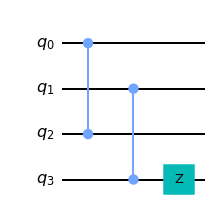

In [5]:
def oracle_f_tilde(n):
    """Oracle circuit that encodes Fourier transformed f = U_f tilde"""
    oracle_f_tilde = QuantumCircuit(n)
    
    # Apply the oracle U_f tilde
    # x·y corresponds to controlled-z gates between first half qubits and second half qubits
    for i in range(int(n/2)):
        oracle_f_tilde.cz(i, i+int(n/2))
    
    # Apply h(y) = y·e_2, which corresponds to the z gate on the second qubit of the second register = q3
    oracle_f_tilde.z(3)
    
    oracle_f_tilde.name = 'Oracle f tilde'
    return oracle_f_tilde

# Display circuit
oracle_f_tilde(n).draw('mpl')

So far, we have implemented the oracles separately. Now we put together those oracles to implement the actual algorithm circuit.

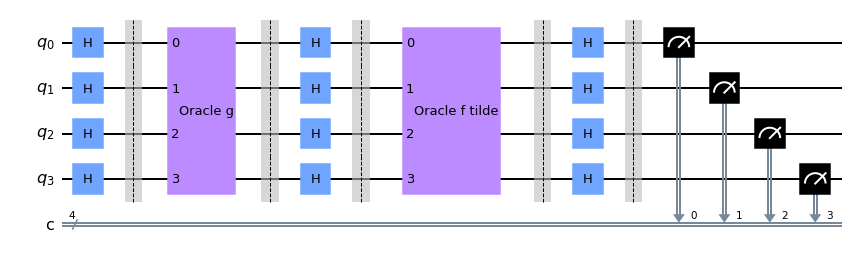

In [6]:
hsp_circuit = QuantumCircuit(n, n)

# Apply Hadamard gates to make superposition
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()    # barrier is for visual separation

# Query the oracle g by appending the oracle circuit on ours
hsp_circuit.append(oracle_g(n), range(n))
hsp_circuit.barrier()

# Apply Hadamard gates to perform a boolean Fourier transform
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Query the oracle f tilde
hsp_circuit.append(oracle_f_tilde(n), range(n))
hsp_circuit.barrier()

# Retrieve s by performing the boolean Fourier transform again
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Measure all qubits
for i in range(n):
    hsp_circuit.measure(i, i)

# Display circuit
hsp_circuit.draw('mpl')

#### 3.1a Experiment with Simulators <a id='ftaa-simulation'> </a>

We can run the above circuit on the simulator.

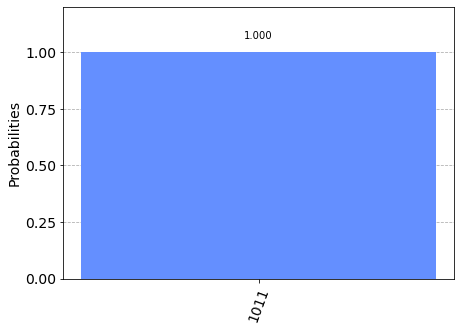

In [7]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

We can see that the result of the measurement is the hidden string `1011`.

#### 3.1b Experiment with Real Devices <a id='ftaa-device'> </a>

We can run the circuit on the real device as below.

In [8]:
# Load our saved IBMQ accounts and get the least busy backend device with more than or equal to n qubits
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x:
                                       int(x.configuration().n_qubits) <= 4*n
                                       and int(x.configuration().n_qubits) >= n
                                       and not x.configuration().simulator
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_santiago


In [9]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_hsp_circuit = transpile(hsp_circuit, backend)
job = backend.run(transpiled_hsp_circuit, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


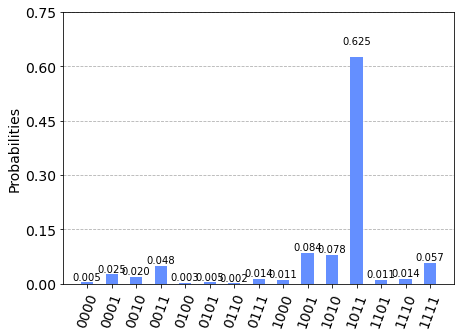

In [10]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can see, there is a significatly higher chance of measuring the hidden shift `1011`. The other results are due to errors in the quantum computation.

### 3.2 Fourier-Transform-Free Algorithm <a id='ftfa'> </a>

Now we go through the more general algorithm, which works without accessing the Fourier transform $\tilde{f}$. We employ the same $n$, $s$, and $f$ used before.

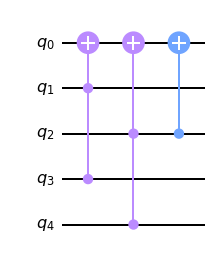

In [11]:
def oracle_f(n):
    """Oracle f"""
    oracle_f = QuantumCircuit(n+1)
    
    # Implement f(x)
    # Now we replace controlled-z gates with Toffoli gates placing NOT gate at the first register
    for i in range(int(n/2)):
        oracle_f.ccx(i+1, i+int(n/2)+1, 0)
    
    # h(x) becomes the controlled-x gate from q2 to q0
    oracle_f.cx(2, 0)
    
    oracle_f.name = 'Oracle f'
    return oracle_f

def oracle_g(n, s):
    """Oracle g"""
    oracle_g = QuantumCircuit(n+1)
    oracle_g.append(shift_s(n, s), qargs=[i+1 for i in range(n)])    # shift the inputs
    oracle_g.append(oracle_f(n), range(n+1))                         # apply the oracle f
    oracle_g.append(shift_s(n, s), qargs=[i+1 for i in range(n)])    # undo the shift
    oracle_g.name = 'Oracle g'
    return oracle_g

# Display the oracle f circuit
oracle_f(n).draw('mpl')

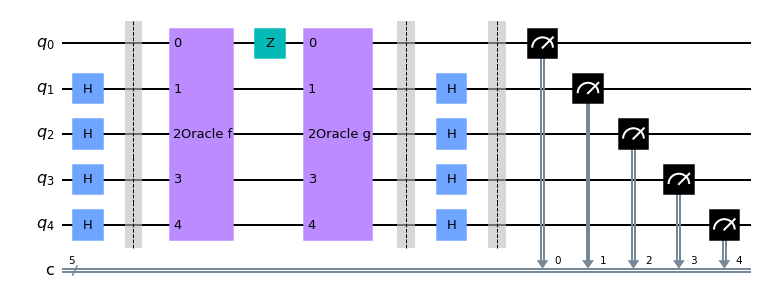

In [12]:
# Implement the Fourier-transform-free algorithm
hsp_circuit = QuantumCircuit(n+1, n+1)

# Apply Hadamard gates to make superposition
for i in range(n):
    hsp_circuit.h(i+1)
hsp_circuit.barrier()    # barrier is for visual separation

# Apply the oracle f, z gate, and the oracle g in order
hsp_circuit.append(oracle_f(n), range(n+1))
hsp_circuit.z(0)
hsp_circuit.append(oracle_g(n, s), range(n+1))
hsp_circuit.barrier()

# Apply Hadamard transform
for i in range(n):
    hsp_circuit.h(i+1)
hsp_circuit.barrier()

# Measure all qubits
for i in range(n+1):
    hsp_circuit.measure(i, i)

# Display circuit
hsp_circuit.draw('mpl')

#### 3.2a Experiment with Simulators <a id='ftfa-simulation'> </a>

We can run the above circuit on the simulator. 

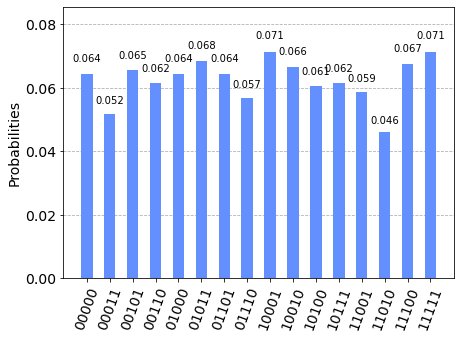

In [13]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

Now we see that there are 16 different outputs. Note that the binary index $b$ is at the first register, so the result string is ordered in $(y, b)$. We can retrieve $s$ as soon as we get four linearly independent outcomes except for the trivial output `00000`. For example, when we get outputs `00011`, `01011`, `10100`, and `11111`, we can compute $s$ as below:

$$
\begin{cases}
    \left<s \mid 0001 \right> = 1 = s_4 \\
    \left<s \mid 0101 \right> = 1 = s_2 + s_4 \\
    \left<s \mid 1010 \right> = 0 = s_1 + s_3 \\
    \left<s \mid 1111 \right> = 1 = s_1 + s_2 + s_3 + s_4
\end{cases}
\quad \therefore \left| s \right> = \left| s_1 s_2 s_3 s_4 \right> = \left| 1011 \right>
$$

Thus, we get the hidden shift `1011` from the given four outcomes. Checking the dot product $(s, 1) \cdot (y, b)$ for all outcome lists as below:

| $$(s, 1)$$ | $$(y, b)$$ | product | $$(s, 1)$$ | $$(y, b)$$ | product |
|:-----:|:-----:|:-----:|:-----:|:-----:|:---------:|
| 10111 | 00000 |   0   | 10111 | 10001 |   1+1=0   |
| 10111 | 00011 | 1+1=0 | 10111 | 10010 |   1+1=0   |
| 10111 | 00101 | 1+1=0 | 10111 | 10100 |   1+1=0   |
| 10111 | 00110 | 1+1=0 | 10111 | 10111 | 1+1+1+1=0 |
| 10111 | 01000 |   0   | 10111 | 11001 |   1+1=0   |
| 10111 | 01011 | 1+1=0 | 10111 | 11010 |   1+1=0   |
| 10111 | 01101 | 1+1=0 | 10111 | 11100 |   1+1=0   |
| 10111 | 01110 | 1+1=0 | 10111 | 11111 | 1+1+1+1=0 |

#### 3.2b Experiment with Real Devices <a id='ftfa-device'> </a>

We can run the circuit on the real device as below.

In [14]:
# Get the least busy backend device with more than or equal to n+1 qubits
backend = least_busy(provider.backends(filters=lambda x:
                                       int(x.configuration().n_qubits) <= 4*(n+1)
                                       and int(x.configuration().n_qubits) >= n+1
                                       and not x.configuration().simulator
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_santiago


In [15]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_hsp_circuit = transpile(hsp_circuit, backend)
job = backend.run(transpiled_hsp_circuit, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


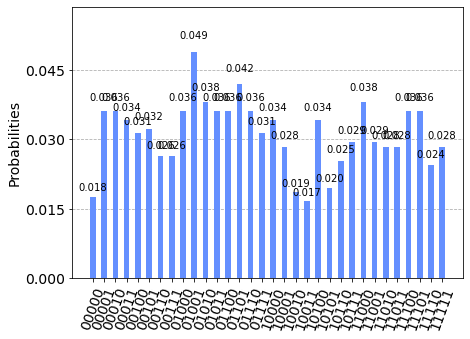

In [16]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In this case, however, we find that desired outputs are not distinguishable from the noise. One reason is that the Toffoli gate is very expensive in current devices. In addition, as the theoretical probability for each desired outcome is only 1/16, this algorithm is fragile to noise. It is also of great interest for quantum researchers to tackle this kind of issue through error correction or error mitigation.

## 4. Problems <a id='problems'> </a>

The function `hsp_oracle` below takes an integer `seed`, and booleans `output`, `shifted` and `fourier_transformed`. It will return the oracle with the input size 4. Find out the hidden shift $s$ using the quantum algorithm.

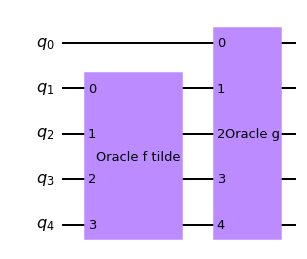

In [17]:
from qiskit_textbook.problems import hsp_oracle
# Example usage
n = 4
seed = 137
oracle_f_tilde = hsp_oracle(seed, output=False, shifted=False, fourier_transformed=True)
oracle_g = hsp_oracle(seed, output=True, shifted=True, fourier_transformed=False)
qc = QuantumCircuit(n+1)
qc.append(oracle_f_tilde, [i+1 for i in range(n)])
qc.append(oracle_g, range(n+1))
qc.draw('mpl')

1. Solve the hidden shift problem over bent functions with an access to the Fourier transform $\tilde{f}$.

In [ ]:
hsp_circuit = QuantumCircuit(n)

####################
# Your codes Here

####################

# Display circuit
hsp_circuit.draw('mpl')

In [ ]:
# Check the result
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

2. Solve the hidden shift problem over bent functions without acceessing the Fourier transform $\tilde{f}$.

In [ ]:
hsp_circuit = QuantumCircuit(n+1)

####################
# Your codes Here

####################

# Display circuit
hsp_circuit.draw('mpl')

In [ ]:
# Check the result
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

## 5. References <a id='references'> </a>

1. M. Roetteler (2008), "Quantum algorithms for highly non-linear Boolean functions", Proceedings of the 21st Annual ACM-SIAM Symposium on Discrete Algorithms (SODA'10), pp. 448-457, [arXiv:0811.3208](https://arxiv.org/abs/0811.3208) [quant-ph]
2. D. Gavinsky, M. Roetteler & J. Roland (2011), "Quantum Algorithm for the Boolean Hidden Shift Problem", 17th International Computing & Combinatorics Conference (COCOON'11), Lecture Notes in Computer Science 6842 (Springer), pp. 158-167, [doi:10.1007/978-3-642-22685-4_14](https://doi.org/10.1007/978-3-642-22685-4_14), [arXiv:1103.3017](https://arxiv.org/abs/1103.3017) [quant-ph]
3. N. Tokareva (2015), "Bent Functions - Results and Applications to Cryptography", Academic Press. 
4. X. Bonnetain & M. Naya-Plasencia (2018), "Hidden Shift Quantum Cryptanalysis and Implications", In: T. Peyrin , S. Galbraith (eds) Advances in Cryptology – ASIACRYPT 2018, Lecture Notes in Computer Science, vol 11272, Springer, Cham, [doi:10.1007/978-3-030-03326-2_19](https://doi.org/10.1007/978-3-030-03326-2_19)
5. K. Wright, K. M. Beck, S. Debnath et al. (2019), "Benchmarking an 11-qubit quantum computer", Nat Commun 10, 5464, [doi:10.1038/s41467-019-13534-2](https://doi.org/10.1038/s41467-019-13534-2)
6. S. Bravyi & D. Gosset (2016), "Improved classical simulation of quantum circuits dominated by Clifford gates", Phys. Rev. Lett. 116, 250501, [doi:10.1103/PhysRevLett.116.250501](https://doi.org/10.1103/PhysRevLett.116.250501), [arXiv:1601.07601](https://arxiv.org/abs/1601.07601) [quant-ph]
<!-- 6. G. Kuperberg (2005), "A subexponential-time quantum algorithm for the dihedral hidden subgroup problem", SIAM Journal on Computing, 35(1), pp. 170-188, [doi:10.1137/S0097539703436345](https://doi.org/10.1137/S0097539703436345), [arXiv:quant-ph/0302112](https://arxiv.org/abs/quant-ph/0302112) -->

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table